In [16]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

import pandas as pd

In [17]:
train_image_path = r'C:\Users\Admin\OneDrive\Desktop\Work\YSU\Lessons\DL_Pytorch\Lesson 7 Introduction to CNN\Pistachio_Image_Dataset\Pistachio_Image_Dataset\train/'
test_image_path = r'C:\Users\Admin\OneDrive\Desktop\Work\YSU\Lessons\DL_Pytorch\Lesson 7 Introduction to CNN\Pistachio_Image_Dataset\Pistachio_Image_Dataset\test/'

In [18]:
os.listdir(train_image_path)[860:870]

['kirmizi 95.jpg',
 'kirmizi 96.jpg',
 'kirmizi 97.jpg',
 'kirmizi 98.jpg',
 'kirmizi 99.jpg',
 'siirt (1).jpg',
 'siirt (10).jpg',
 'siirt (11).jpg',
 'siirt (12).jpg',
 'siirt (13).jpg']

In [19]:
img = cv2.imread(train_image_path + "\\" + os.listdir(train_image_path)[0])

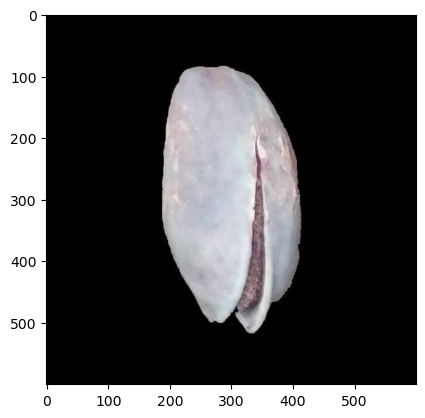

In [20]:
plt.imshow(img)

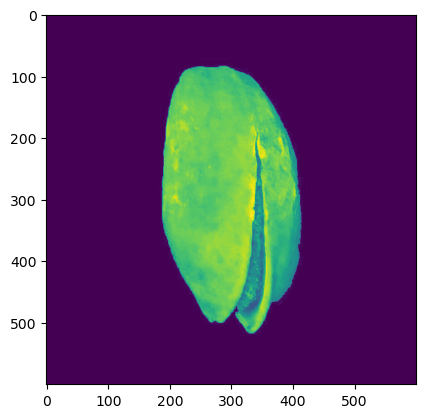

In [21]:
plt.imshow(img[:, :, 0])

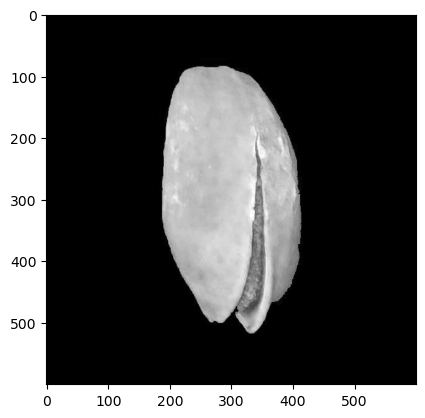

In [22]:
plt.imshow(img[:, :, 0], cmap = 'gray')

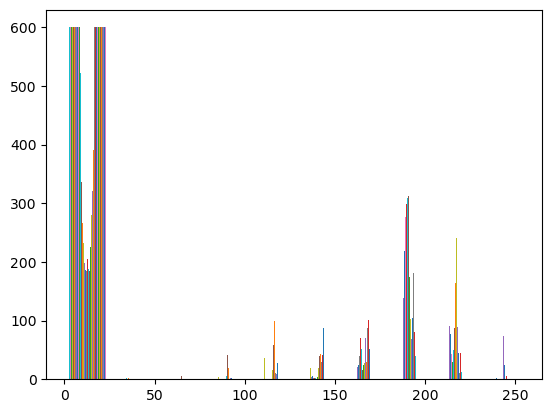

In [23]:
plt.hist(img[:, :, 0]);

In [24]:
img.shape

(600, 600, 3)

In [25]:
scale_percent = 60 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

In [26]:
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [27]:
resized.shape

(360, 360, 3)

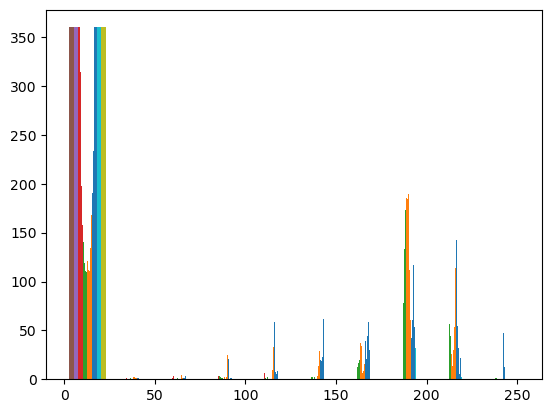

In [28]:
plt.hist(resized[:, :, 0]);

In [29]:
train_labels = [file_name.split(" ")[0] for file_name in os.listdir(train_image_path)]
test_labels = [file_name.split(" ")[0] for file_name in os.listdir(test_image_path)]

In [30]:
train_df = pd.DataFrame(columns=["img_name","label"])
train_df["img_name"] = os.listdir(train_image_path)
for idx, i in enumerate(os.listdir(train_image_path)):
    if "kirmizi" in i:
        train_df["label"][idx] = 0
    if "siirt" in i:
        train_df["label"][idx] = 1

In [31]:
train_df.head()

,img_name,label
0,kirmizi (1).jpg,0
1,kirmizi (10).jpg,0
2,kirmizi (11).jpg,0
3,kirmizi (12).jpg,0
4,kirmizi (13).jpg,0


In [32]:
train_df.to_csv(r'train_csv.csv', index = False, header=True)

In [33]:
test_df = pd.DataFrame(columns=["img_name","label"])
test_df["img_name"] = os.listdir(test_image_path)
for idx, i in enumerate(os.listdir(test_image_path)):
    if "kirmizi" in i:
        test_df["label"][idx] = 0
    if "siirt" in i:
        test_df["label"][idx] = 1

In [34]:
test_df.head()

,img_name,label
0,kirmizi 1000.jpg,0
1,kirmizi 1001.jpg,0
2,kirmizi 1002.jpg,0
3,kirmizi 1003.jpg,0
4,kirmizi 1004.jpg,0


In [35]:
test_df.to_csv (r'test_csv.csv', index = False, header=True)

# Creating Model

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torch.optim as optim

from tqdm import tqdm_notebook

from PIL import Image

import torchvision.models as models

from torch.utils.data import Dataset

import warnings

In [37]:
class Pistachio(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [55]:
batch_size = 10
shuffle = True
pin_memory = True

In [56]:
dataset = Pistachio(train_image_path, "train_csv.csv",transform=transform)
train_set, validation_set = torch.utils.data.random_split(dataset,[1500,115])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,pin_memory=pin_memory)
validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size, pin_memory=pin_memory)

In [57]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [62]:
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [63]:
for epoch in tqdm_notebook(range(20)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device=device))
        loss = criterion(outputs.to(device=device), labels.type(torch.LongTensor).to(device=device))
        loss.backward()
        optimizer.step()

        print(loss)

C:\Users\Admin\AppData\Local\Temp\ipykernel_29428\2179853303.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(20)):  # loop over the dataset multiple times


  0%|          | 0/20 [00:00<?, ?it/s]

tensor(2.2252, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1695, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0569, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9731, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9232, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7438, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4547, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9669, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2468, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6510, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5802, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3813, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9749, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7129, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2692, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9884, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6007, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.6253, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5731, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0874, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5563, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9665, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8863, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7017, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8038, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6980, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8500, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6569, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5766, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8562, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6779, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7033, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.6673, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9607, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4124, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3306, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4927, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3203, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2694, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1988, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2250, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9880, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4104, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3831, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2357, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5146, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7999, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4262, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.8602, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4529, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1805, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4200, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2996, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3664, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3712, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2605, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2586, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3760, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5066, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4112, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2901, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1670, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5430, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8420, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.2689, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3781, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1782, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4611, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7434, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4638, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5043, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3638, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5563, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3198, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2892, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1286, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6270, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1556, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4141, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2793, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6366, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.6185, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2880, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1349, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3937, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3116, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4975, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5496, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6303, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4069, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5107, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4769, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2220, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3661, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2165, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3775, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3355, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.2102, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2546, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2154, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7279, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4924, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2593, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1048, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6081, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2782, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2711, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2354, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2443, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4024, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2150, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4444, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2511, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.2638, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6629, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4915, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3137, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6255, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5082, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5762, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1550, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3600, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3259, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2932, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5810, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5294, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3323, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3985, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1631, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1625, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.3308, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2294, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2515, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0595, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4563, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2947, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4115, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7291, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3922, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3175, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2969, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0930, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4036, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4495, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6665, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.8092, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3791, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3823, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4607, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6841, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4465, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3688, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3359, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3535, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3271, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2419, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2474, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3109, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4885, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5644, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4228, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1086, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.1567, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6688, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4785, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5218, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4331, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6088, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2464, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2659, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7548, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2089, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8207, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2666, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1953, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2120, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.4375, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2112, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4232, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1813, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2843, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3114, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3384, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3169, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1379, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0680, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5965, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5348, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2955, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1306, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2786, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1815, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.1333, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1624, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1340, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5308, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4819, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5886, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3162, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1539, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4043, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3711, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1887, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3106, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2384, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2673, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.5223, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6340, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2999, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2881, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2741, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2302, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4032, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2253, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3275, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2832, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2390, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5698, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3538, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4476, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.1385, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3793, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0611, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0713, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1135, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7404, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2086, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4611, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1941, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2829, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0667, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2989, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2304, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3917, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2539, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4300, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.1813, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2145, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1061, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2137, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6246, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4101, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3384, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2811, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2985, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0835, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4273, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2997, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3907, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3731, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2377, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1590, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.4146, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4845, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1693, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2916, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5173, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3783, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1597, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5643, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1364, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2195, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3127, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1531, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1619, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2974, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2904, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3125, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.0486, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3066, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4131, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2833, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4434, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7751, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4515, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2671, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3034, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0572, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7081, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4380, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3898, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1526, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2892, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3177, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3741, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.4566, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4682, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3138, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3949, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3214, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8412, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1788, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2059, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3061, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1550, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1131, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0503, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1463, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1022, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1267, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.2413, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1636, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5451, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3823, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3115, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1427, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1069, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5575, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2490, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5055, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2806, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2011, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1370, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2497, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0729, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.1738, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1925, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0533, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1707, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0513, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4094, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0065, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6560, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2262, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7610, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2649, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8579, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3642, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1015, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4039, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3553, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.4289, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2533, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3478, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1018, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2596, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1612, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0630, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2872, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5600, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4158, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2559, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3600, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1666, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2010, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1980, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4771, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3906, device='cuda:0', grad_fn=<NllLossBackward

In [65]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


In [75]:
classes = ["0", "1"]

In [94]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.cpu() == prediction.cpu():
                correct_pred[classes[int(label.cpu().numpy())]] += 1
            total_pred[classes[int(label.cpu().numpy())]] += 1

In [95]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 67.2 %
Accuracy for class: 1     is 93.0 %
